# Basics with numerical time-series

* Find this notebook at `EpyNN/epynnlive/dummy_time/train.ipynb`.
* Regular python code at `EpyNN/epynnlive/dummy_time/train.py`.

Run the notebook online with [Google Colab](https://colab.research.google.com/github/Synthaze/EpyNN/blob/main/epynnlive/dummy_time/train.ipynb).

**Level: Intermediate**

In this notebook we will review:

* Handling univariate time series data to proceed with Neural Network regression.
* Training of Feed-Forward (FF) and Recurrent Neural Network (RNN) for binary classification tasks.
* Overfitting of the model to the training data and the impact of Dropout regularization.

**It is assumed that the following *basics* notebooks were already reviewed:**

* [Basics with Perceptron (P)](../dummy_boolean/train.ipynb)
* [Basics with string sequence](../dummy_string/train.ipynb)

**<font color='red'>This notebook does not enhance, extend or replace EpyNN's documentation.</font>**

**Relevant documentation pages for the current notebook:**

* [Fully Connected (Dense)](https://epynn.net/Dense.html)
* [Recurrent Neural Network (RNN)](https://epynn.net/RNN.html)
* [Dropout - Regularization](https://epynn.net/Dropout.html)

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, sample features are univariate time series which may consist of only white noise (negative) or white noise supplemented with a pure sine-wave of random frequency (positive). 

The goal of the game is to train a Neural Network which may be able to detect if sample features do or do not contain a true signal.

In [1]:
# EpyNN/epynnlive/dummy_time/train.ipynb
# Install dependencies
!git clone https://github.com/synthaze/EpyNN
!pip3 install -r EpyNN/requirements.txt
import sys
sys.path.insert(1, '/content/EpyNN')

# Standard library imports
import random

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np

# Local application/library specific imports
import epynn.initialize
from epynn.commons.maths import relu, softmax
from epynn.commons.library import (
    configure_directory,
    read_model,
)
from epynn.network.models import EpyNN
from epynn.dropout.models import Dropout
from epynn.embedding.models import Embedding
from epynn.flatten.models import Flatten
from epynn.rnn.models import RNN
from epynn.dense.models import Dense
from epynnlive.dummy_time.prepare_dataset import prepare_dataset
from epynnlive.dummy_time.settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)
np.random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=1024)

Let's control what we retrieved.

In [2]:
print(X_features[0].shape)
print(X_features[0])

(128, 1)
[[-0.35376783]
 [-0.17895082]
 [-0.29156932]
 ...
 [-0.25263271]
 [-0.74700792]
 [-0.16726332]]


This is called a *univariate time series* because it contains a single measurement per time step. Note we retrieved data with a sampling rate of 128 Hz and duration of 1 second for a total of 128 points.

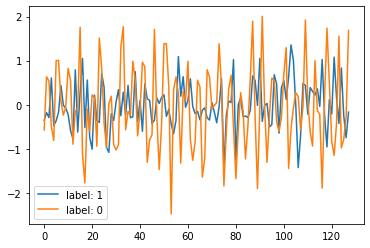

In [3]:
plt.plot(X_features[0], label='label: %s' % Y_label[0])
plt.plot(X_features[1], label='label: %s' % Y_label[1])
plt.legend()
plt.show()
plt.close()

While sample features corresponding to ``label: 1`` do not contain a true signal, sample features corresponding to ``label: 0`` do contain a true signal of random frequency.

## Feed-Forward (FF)

Feed-Forward Neural Networks are advantageous compared to other architectures because they are relatively fast to train, and most often less sensitive to parameters of training, also called *hyperparameters*. Therefore, they are most commonly a first choice when dealing with a new problem and prior to further insights.

### Embedding

In EpyNN, sample features (X_features) and labels (Y_label) are passed to the corresponding arguments value when instantiating the *embedding* or *input* layer. It is required to use this layer in EpyNN, which is then always the first layer of the network architecture. The layer consists of a simple forward pass but contains several routines to prepare data according to user choices.

In [4]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      Y_encode=True,
                      relative_size=(2, 1, 0))

Herein, we instructed to the class constructor ``Embedding`` to one-hot encode the set of sample label ``Y_encode=True``. We also instructed to split data in order to build a training set contraining ``2/3`` of the whole set while the validation set will contain ``1/3``.

The training procedure is exclusively driven by the training data. However, one may judge how general the model can be by comparing metrics with evaluation on the validation set.

### Flatten-(Dense)n

As introduced before, sample features are univariate time series and as such the set of sample features has 3 dimensions.

In [5]:
print(embedding.dtrain.X.shape)    # (m, s, v)

(683, 128, 1)


It contains 683 samples (m), each described by a sequence of 128 features (s) containing 1 element (v).

However, the fully-connected or *dense* layer can only process bi-dimensionnal input arrays. That is the reason why we need to invoke a *flatten* layer in between the *embedding* and *dense* layer.

In [6]:
flatten = Flatten()

# Original shape (m, s, v)
print(embedding.dtrain.X.shape)

# Flatten on forward pass (m, s * v)
print (flatten.forward(embedding.dtrain.X).shape)

# Reverse on backward pass (m, s, v)
print (flatten.backward(flatten.forward(embedding.dtrain.X)).shape)

(683, 128, 1)
(683, 128)
(683, 128, 1)


In other words, the *flatten* layer is an adapter.

Let's now build the network architecture.

In [7]:
name = 'Flatten_Dense-64-relu_Dense-2-softmax'

# Tune defaults learning rate from 0.1 to 0.005
se_hPars['learning_rate'] = 0.005

flatten = Flatten()

hidden_dense = Dense(64, relu)

dense = Dense(2, softmax)

layers = [embedding, flatten, hidden_dense, dense]

model = EpyNN(layers=layers, name=name)

The network - or model - architecture is composed of the mandatory *embedding* input layer, one *hidden_dense* layer with 64 nodes and *ReLU* activation function and finally an output *dense* layer with 2 nodes - because we have two distinct one-hot encoded labels - and a *softmax* activation function.

We now initialize the model and instruct it to use a *Mean Square Error* cost function with network *seeding* for reproducibility and we provide our custom hyperparameters.

In [8]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

The initialize method performs a dry epoch which includes all steps but omits parameters update.

We can now proceed with the training.

In [9]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 0/0 - Accuracy: 1.0 Cost: 0.00075 - TIME: 7.75s RATE: 1.29e+01e/s TTC: 0s          

+-------+----------+----------+----------+-------+--------+-------+--------------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |                    Experiment                    |
|       |  Dense   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                  |
+-------+----------+----------+----------+-------+--------+-------+--------------------------------------------------+
|   0   | 5.00e-03 | 5.00e-03 |  0.722   | 0.695 | 0.197  | 0.214 | 1635012768_Flatten_Dense-64-relu_Dense-2-softmax |
|  10   | 5.00e-03 | 5.00e-03 |  0.975   | 0.868 | 0.031  | 0.097 | 1635012768_Flatten_Dense-64-relu_Dense-2-softmax |
|  20   | 5.00e-03 | 5.00e-03 |  1.000   | 0.894 | 0.008  | 0.080 | 1635012768_Flatten_Dense-64-relu_Dense-2-softmax |
|  30   | 5.00e-03 | 5.00e-03 |  1.000   | 0.900 | 0.004  | 0.077

We can observe on the logs that an accuracy of 1 was reached after 40 iterations on the training set with a cost near zero. By contrast, we can observe that - although good - the metrics and cost computed on the validation set ran behind from the early epochs of the regression.

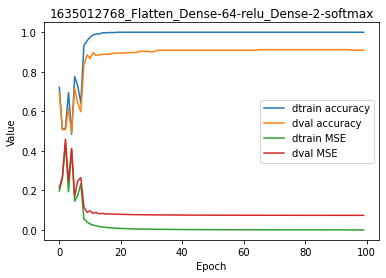

In [10]:
model.plot(path=False)

When plotting the accuracy and cost for training and validation sets, these differences are even more obvious.

This is called *overfitting* of the model to the training data. In other words, the model represents very well - and even exactly - the data from which it was trained, but lacks such performance on independant data.

There are many ways to limit such overfitting when designing or training a Neural Network. Herein we are going to experiment the *dropout* regularization method to see how it can impact such unwanted overfitting behavior.

For code, maths and pictures behind the *Flatten* and *Dense* layers, follow these links:

* [Flatten - Adapter](https://epynn.net/Flatten.html)
* [Fully Connected (Dense)](https://epynn.net/Dense.html)

### Flatten-(Dense)n with Dropout

You can follow [this link]() for details on the *dropout* layer.

Briefly, the *Dropout* regularization layer randomly subsamples the output of the previous layer and forwards the product to the next layer. By introducing such instability in the network, the layer reduces the thinning capacity of the network which may be of interest to prevent overfitting, which happens when the model is too closely related to the training data.

In EpyNN, the class constructor ``Dropout()`` takes a single argument ``drop_prob`` which represents the probability of one element in the input array to be preserved in the output array.

For instance.

In [11]:
test_array = np.random.standard_normal((5, 5))

D1 = (np.random.uniform(0, 1, test_array.shape) < 1)
D05 = (np.random.uniform(0, 1, test_array.shape) < 0.5)
D0 = (np.random.uniform(0, 1, test_array.shape) < 0)

print(test_array)
print(test_array * D1)    # drop_prob = 1 - No dropout
print(test_array * D05)   # drop_prob = 0.5 - Common value
print(test_array * D0)    # drop_prob = 0 - Output is null

[[-0.40461632  0.56992124 -0.188923   -1.92933133 -0.69195013]
 [ 1.04594288 -0.42813771  0.89180849  0.84383519  0.65651707]
 [-0.42446322 -1.20019422  2.12126642  0.27575357 -0.67915118]
 [-0.79589247 -0.40698592 -1.54560858  0.40910712 -0.89735926]
 [-1.02323887 -0.73387254 -0.17314366  0.50633278  2.35972254]]
[[-0.40461632  0.56992124 -0.188923   -1.92933133 -0.69195013]
 [ 1.04594288 -0.42813771  0.89180849  0.84383519  0.65651707]
 [-0.42446322 -1.20019422  2.12126642  0.27575357 -0.67915118]
 [-0.79589247 -0.40698592 -1.54560858  0.40910712 -0.89735926]
 [-1.02323887 -0.73387254 -0.17314366  0.50633278  2.35972254]]
[[-0.40461632  0.56992124 -0.         -1.92933133 -0.69195013]
 [ 0.         -0.          0.89180849  0.          0.        ]
 [-0.42446322 -1.20019422  2.12126642  0.27575357 -0.67915118]
 [-0.79589247 -0.40698592 -1.54560858  0.40910712 -0.89735926]
 [-0.         -0.         -0.          0.          2.35972254]]
[[-0.  0. -0. -0. -0.]
 [ 0. -0.  0.  0.  0.]
 [-0. 

Usually, values for ``drop_prob`` are within 0-0.5.

Let’s build the same Feed-Forward network as above but with the implementation of two *Dropout* layers.

In [12]:
name = 'Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax'

se_hPars['learning_rate'] = 0.005

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.5)

dense = Dense(2, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We have set up a first *dropout1* between the *flatten* and *hidden_dense* layer as well as a second one between *hidden_dense* and *dense*.

Note the ``drop_prob`` values are different for the two *dropout* layers. We will dropt 0.2 of the input for the first, and 0.5 for the second. Those settings are quite empirical, better just to test and see.

Initialize with the same settings as is the no-dropout setup.

In [13]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

You can see the *dropout* layers did appear in the check. Let's proceed with training.

In [14]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 0/0 - Accuracy: 0.993 Cost: 0.0111 - TIME: 8.1s RATE: 1.23e+01e/s TTC: 0s          

+-------+----------+----------+----------+-------+--------+-------+------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |                               Experiment                               |
|       |  Dense   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                        |
+-------+----------+----------+----------+-------+--------+-------+------------------------------------------------------------------------+
|   0   | 5.00e-03 | 5.00e-03 |  0.518   | 0.510 | 0.303  | 0.305 | 1635012776_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  10   | 5.00e-03 | 5.00e-03 |  0.791   | 0.736 | 0.143  | 0.173 | 1635012776_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  20   | 5.00e-03 | 5.00e-03 |  0.922   | 0.891 | 0

It is clear that the delta between training and validation set is much reduced now, both for accuracy metrics and MSE cost.

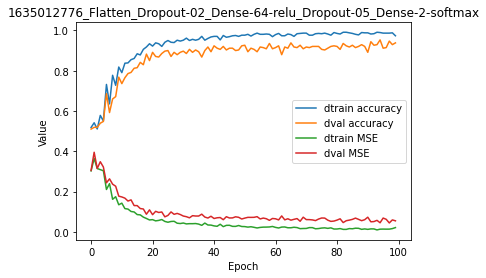

In [15]:
model.plot(path=False)

In brief, think about using *dropout* layers to reduce overfitting, alone or in combination with other methods.

For code, maths and pictures behind the *Dropout* layer, follow these links:

* [Dropout - Regularization](https://epynn.net/Dropout.html)

## Recurrent Neural Network (RNN)

When dealing with any sort of sequential data, it is often suggested to use recurrent architectures because they can process three-dimensional input arrays and take advantage of the *sequential* nature of sample features.

### Embedding

Let's embed our data again, using the same settings as before, and proceed with a little refresh.

In [16]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      Y_encode=True,
                      relative_size=(2, 1, 0))

print(embedding.dtrain.X.shape)        # (m, s, v)
print(embedding.dtrain.X[:, 0].shape)  # Input shape at sequence step 0

(683, 128, 1)
(683, 1)


We have 683 samples (m) with sequential features of length 128 (s) which represents a univariate time series (v).

We recalled before that sample features may be white noise, or white noise combined with a pure sine-wave of random frequency. While there is no expected **correlation through time** within the white noise, we expect a **periodic pattern** to repeat in the case where a pure since-wave is also present in sample features.

Recurrent layers are said to have some internal memory of such periodic patterns because:

* One recurrent layer is made of recurrent units or cells.
* One unit processes every step in one sequence at time within a ``for`` loop.
* The trick is: the output of every iteration - every step - is *fed back* in the unit for every *step forward* along the sequence.

Said differently, the output of one recurrent cell does not only depend of the input at a given sequence step.

This output of one iteration in sequence, called ``h`` for *hidden cell state*, becomes more and more "impregnated" by outputs of previous iterations along with the step forward in the sequence.

These statements may be hard to understand. See [RNN - Forward](https://epynn.net/RNN.html) for some graphical elements.

### RNN-Dense

Below we will instantiate a simple *RNN* layer composed of 10 cells which forward the last (10th) hidden state to the output *dense* layer. 

In [17]:
name = 'RNN-10_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.01
se_hPars['softmax_temperature'] = 5

rnn = RNN(10)

dense = Dense(2, softmax)

layers = [embedding, rnn, dense]

model = EpyNN(layers=layers, name=name)

In contrast to the Feed-Forward network seen above, the *Flatten* layer is absent herein. This is because RNN returns the last hidden state of shape (10,). The flatten operation is therefore unnecessary. Note that RNN in EpyNN may return all hidden states sequences (``RNN(10, sequences=True)``) which then would require the use of a flatten layer because the shape would be (128, 10).

Let's give a try to this RNN-based network.

In [18]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Start training.

In [19]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 0/0 - Accuracy: 0.693 Cost: 0.2105 - TIME: 30.35s RATE: 3.29e+00e/s TTC: 1s        

+-------+----------+----------+----------+-------+--------+-------+-------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |                Experiment                 |
|       |   RNN    |  Dense   |  dtrain  | dval  | dtrain | dval  |                                           |
+-------+----------+----------+----------+-------+--------+-------+-------------------------------------------+
|   0   | 1.00e-02 | 1.00e-02 |  0.533   | 0.499 | 0.248  | 0.251 | 1635012784_RNN-10_Flatten_Dense-2-softmax |
|  10   | 1.00e-02 | 1.00e-02 |  0.561   | 0.507 | 0.247  | 0.249 | 1635012784_RNN-10_Flatten_Dense-2-softmax |
|  20   | 1.00e-02 | 1.00e-02 |  0.564   | 0.510 | 0.245  | 0.248 | 1635012784_RNN-10_Flatten_Dense-2-softmax |
|  30   | 1.00e-02 | 1.00e-02 |  0.581   | 0.513 | 0.242  | 0.246 | 1635012784_RNN-10_Flatten_Dense-2-softmax |
| 

We observe that the model was still converging at the end of the training. Interestingly, there is no overfitting at all. *Accuracy* and *cost* (MSE) are even higher and lower, respectively, for the validation set. 

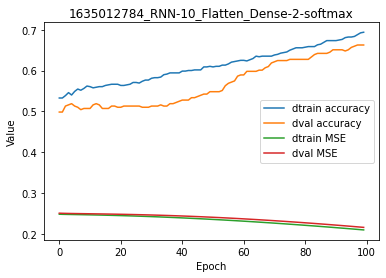

In [20]:
model.plot(path=False)

It is clear that this model would need more training epochs to converge, but this would not fix the overfitting problem.

For code, maths and pictures behind the *RNN* layer, follow this link:

* [Recurrent Neural Network (RNN)](https://epynn.net/RNN.html)

### RNN-Dense with SGD

In the above-example we used Gradient Descent (GD) optimization, meaning that:

* All training examples are in a single batch.
* There is a single weight update by the training epoch.

Below we set ``batch_size`` to ``32`` to use Stochastic Gradient Descent (SGD), meaning that:

* All training examples are divided into batches of size 32, yielding ``N_SAMPLES // 32`` batches.
* There are as many weight update by training epochs than training batches.

In [21]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

We use the same network as before.

In [22]:
name = 'RNN-10_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.01
se_hPars['softmax_temperature'] = 5

rnn = RNN(10)

dense = Dense(2, softmax)

layers = [embedding, rnn, dense]

model = EpyNN(layers=layers, name=name)

We initialize and train the nework.

In [23]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 20/20 - Accuracy: 0.969 Cost: 0.02007 - TIME: 57.12s RATE: 1.75e+00e/s TTC: 1s     

+-------+----------+----------+----------+-------+--------+-------+-------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |                Experiment                 |
|       |   RNN    |  Dense   |  dtrain  | dval  | dtrain | dval  |                                           |
+-------+----------+----------+----------+-------+--------+-------+-------------------------------------------+
|   0   | 1.00e-02 | 1.00e-02 |  0.540   | 0.516 | 0.247  | 0.250 | 1635012814_RNN-10_Flatten_Dense-2-softmax |
|  10   | 1.00e-02 | 1.00e-02 |  0.638   | 0.630 | 0.226  | 0.230 | 1635012814_RNN-10_Flatten_Dense-2-softmax |
|  20   | 1.00e-02 | 1.00e-02 |  0.900   | 0.903 | 0.119  | 0.117 | 1635012814_RNN-10_Flatten_Dense-2-softmax |
|  30   | 1.00e-02 | 1.00e-02 |  0.895   | 0.900 | 0.097  | 0.094 | 1635012814_RNN-10_Flatten_Dense-2-softmax |
| 

For the same number of training epochs, accuracy is much higher.

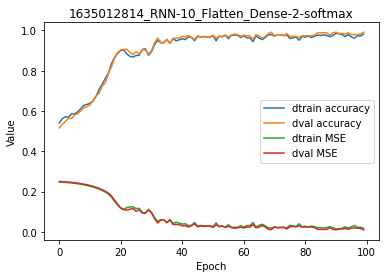

In [24]:
model.plot(path=False)

And there is no overfitting, this is an excellent model.

For code, maths and pictures behind the *RNN* layer, follow this link:

* [Recurrent Neural Network (RNN)](https://epynn.net/RNN.html)

## Write, read & Predict

A trained model can be written on disk such as:

In [25]:
model.write()

# model.write(path=/your/custom/path)

Make: /media/synthase/beta/EpyNN/epynnlive/dummy_time/models/1635012814_RNN-10_Flatten_Dense-2-softmax.pickle


A model can be read from disk such as:

In [26]:
model = read_model()

# model = read_model(path=/your/custom/path)

We can retrieve new features and predict on them.

In [27]:
X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features)

Results can be extracted such as:

In [28]:
for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

0 0 [0.98718813 0.01281187]
1 0 [0.94121987 0.05878013]
2 1 [0.02139625 0.97860375]
3 0 [0.95959614 0.04040386]
4 1 [0.02610764 0.97389236]
5 1 [0.01849713 0.98150287]
6 1 [0.018713 0.981287]
7 1 [0.01967183 0.98032817]
8 0 [0.96032797 0.03967203]
9 0 [0.93915586 0.06084414]
